In [3]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 4.3 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1

In [5]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.9 MB/s eta 0:00:0000:0100:01


In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
from collections import Counter
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


# Transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 라벨 파일 로드
with open('categories_places365.txt') as f:
    labels = [line.strip().split(' ')[0][3:] for line in f]

def classify_frame(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        _, predicted = output.max(1)
    return labels[predicted.item()]

def classify_folder(folder_path):
    class_count = Counter()
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_file in image_files:
        room_type = classify_frame(image_file)
        class_count[room_type] += 1

    # 다수결 투표로 방 종류 결정
    if class_count:
        most_common_class = class_count.most_common(1)[0][0]
        return most_common_class
    return "unknown"

# 프레임 이미지 폴더 경로 설정
root_dir = "open-eqa/data/frames/scannet-v0"
folders = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

room_count = Counter()

for folder in folders:
    room_type = classify_folder(folder)
    room_count[room_type] += 1

# 결과 출력
for room, count in room_count.items():
    print(f"{room}: {count} videos")


--2024-05-19 00:37:00--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘resnet50_places365.pth.tar’

     0K .......... .......... .......... .......... ..........  0%  127K 12m27s
    50K .......... .......... .......... .......... ..........  0%  255K 9m19s
   100K .......... .......... .......... .......... ..........  0% 40.7M 6m13s
   150K .......... .......... .......... .......... ..........  0% 68.1M 4m40s
   200K .......... .......... .......... .......... ..........  0%  256K 4m58s
   250K .......... .......... .......... .......... ..........  0% 55.7M 4m9s
   300K .......... .......... .......... .......... ..........  0% 59.1M 3m33s
   350K .......... .......... .......... ..........

utility_room: 6 videos
dorm_room: 10 videos
pantry: 2 videos
office: 14 videos
closet: 6 videos
waiting_room: 6 videos
kitchen: 5 videos
home_office: 4 videos
hospital_room: 1 videos
bathroom: 9 videos
recreation_room: 1 videos
office_cubicles: 2 videos
classroom: 1 videos
hotel_room: 4 videos
berth: 3 videos
conference_room: 5 videos
music_studio: 1 videos
nursery: 1 videos
laundromat: 1 videos
galley: 1 videos
dining_room: 2 videos
bookstore: 1 videos
veterinarians_office: 1 videos
home_theater: 1 videos
corridor: 1 videos


In [48]:
### to df
import pandas as pd
df = pd.DataFrame.from_dict(room_count, orient='index').reset_index()
df.columns = ['room', 'count']
df = df.sort_values(by='count', ascending=False)
df = df.reset_index(drop=True)
df.to_csv('room_count.csv', index=False)
print(df)

                    room  count
0                 office     14
1              dorm_room     10
2               bathroom      9
3           waiting_room      6
4           utility_room      6
5                 closet      6
6                kitchen      5
7        conference_room      5
8            home_office      4
9             hotel_room      4
10                 berth      3
11       office_cubicles      2
12                pantry      2
13           dining_room      2
14          home_theater      1
15                galley      1
16  veterinarians_office      1
17             bookstore      1
18             classroom      1
19            laundromat      1
20               nursery      1
21          music_studio      1
22       recreation_room      1
23         hospital_room      1
24              corridor      1


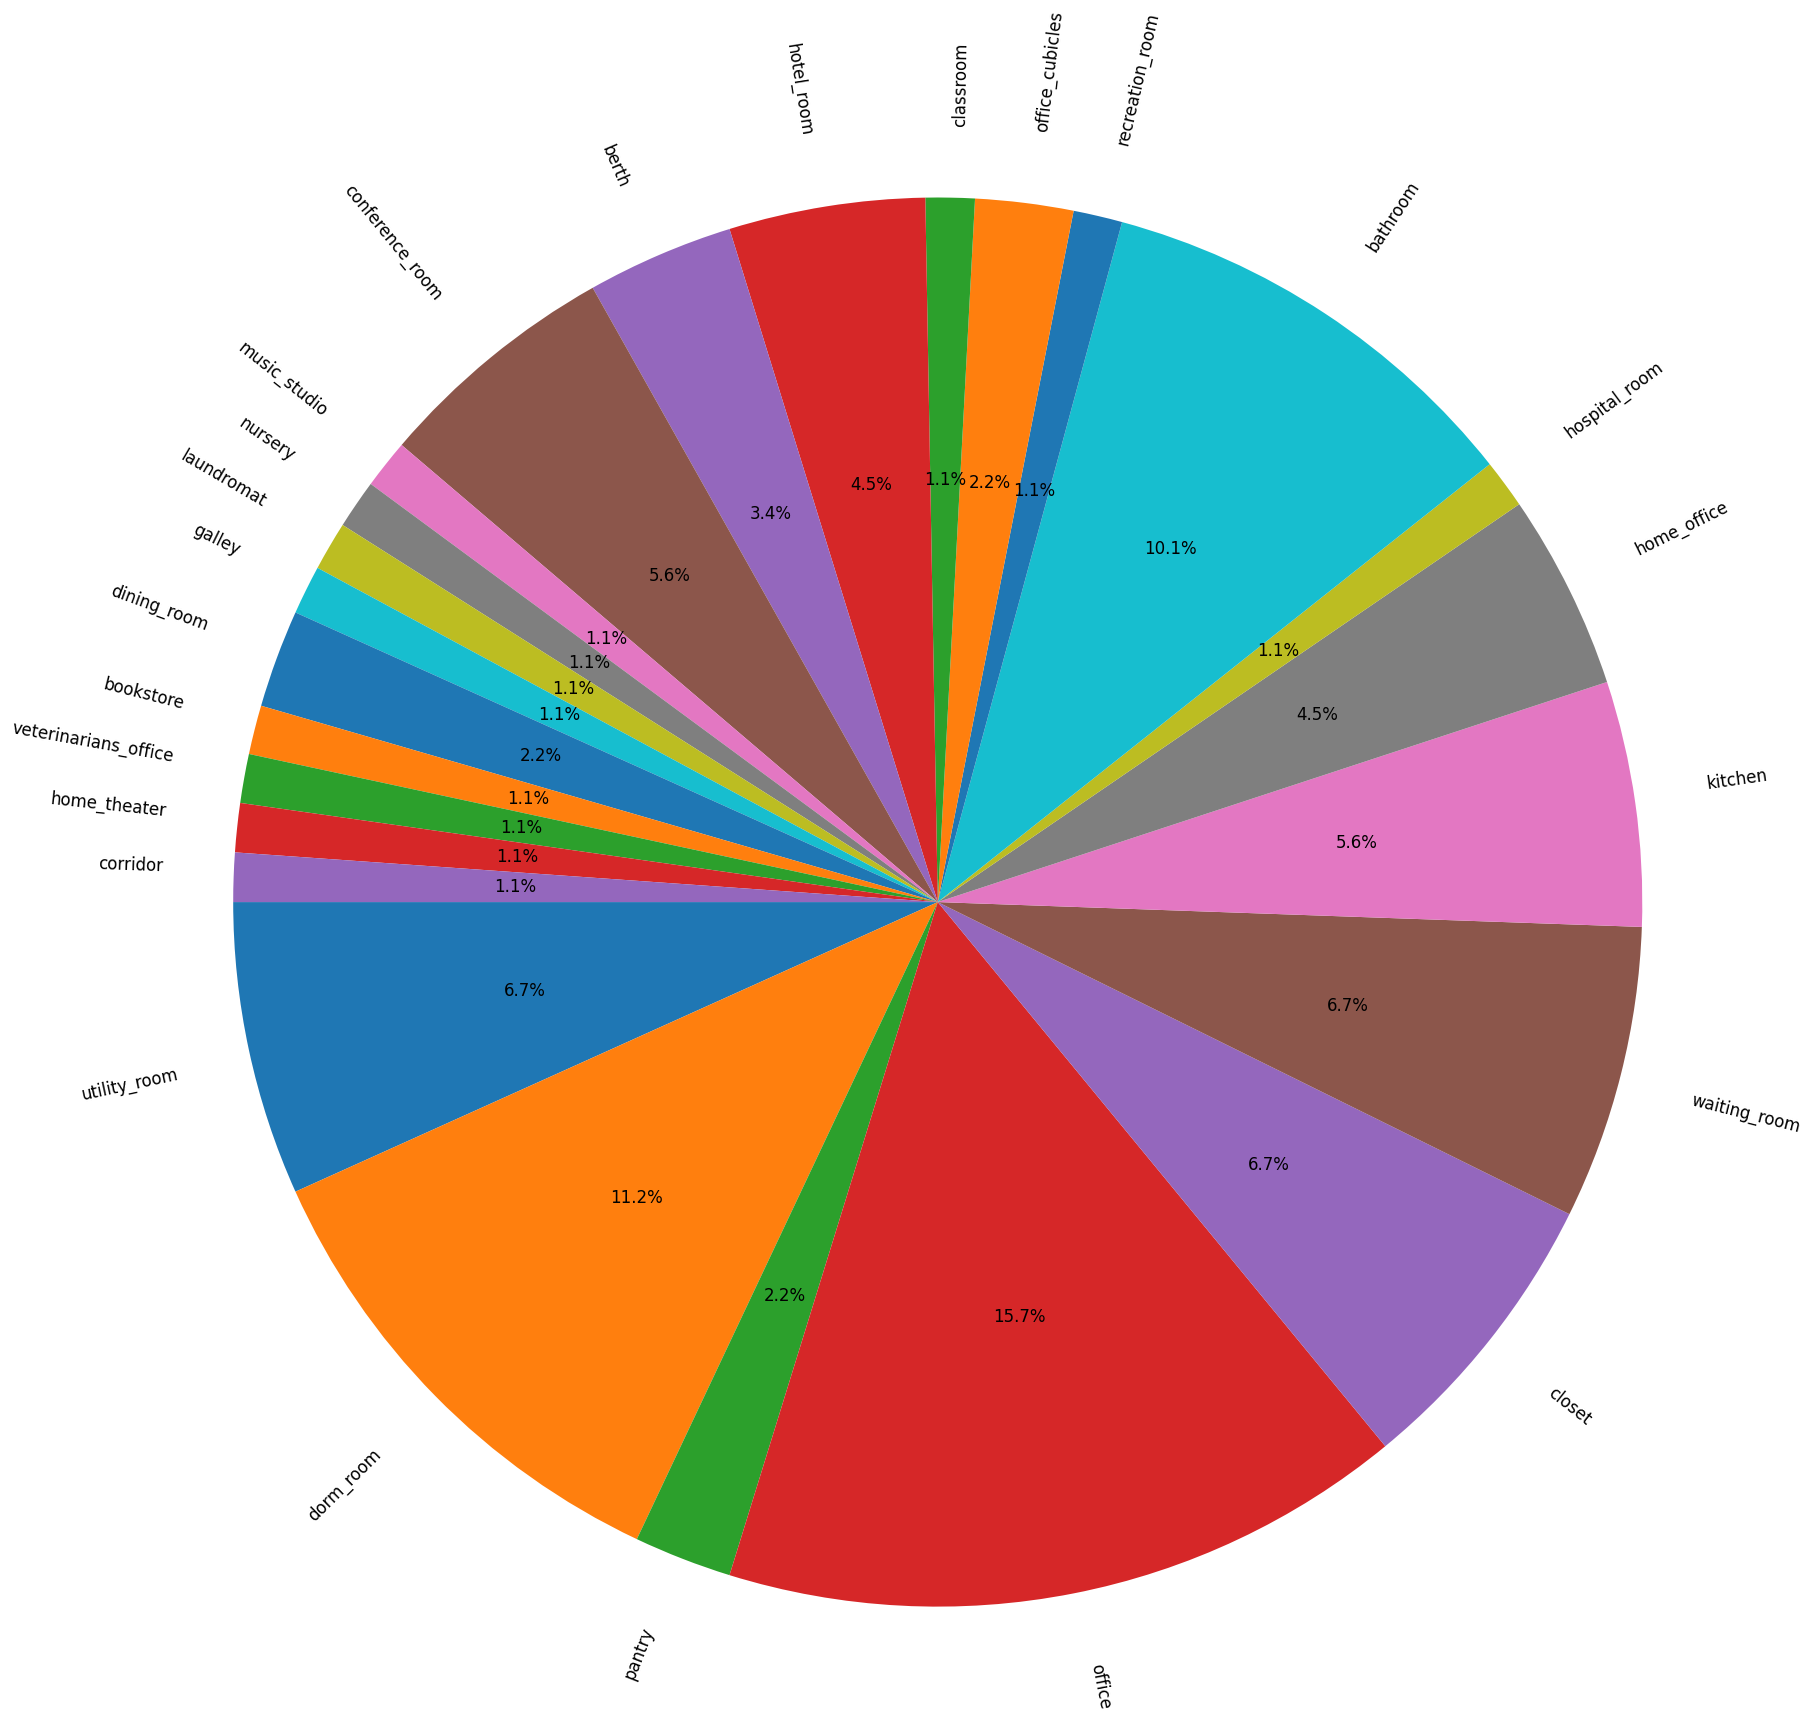

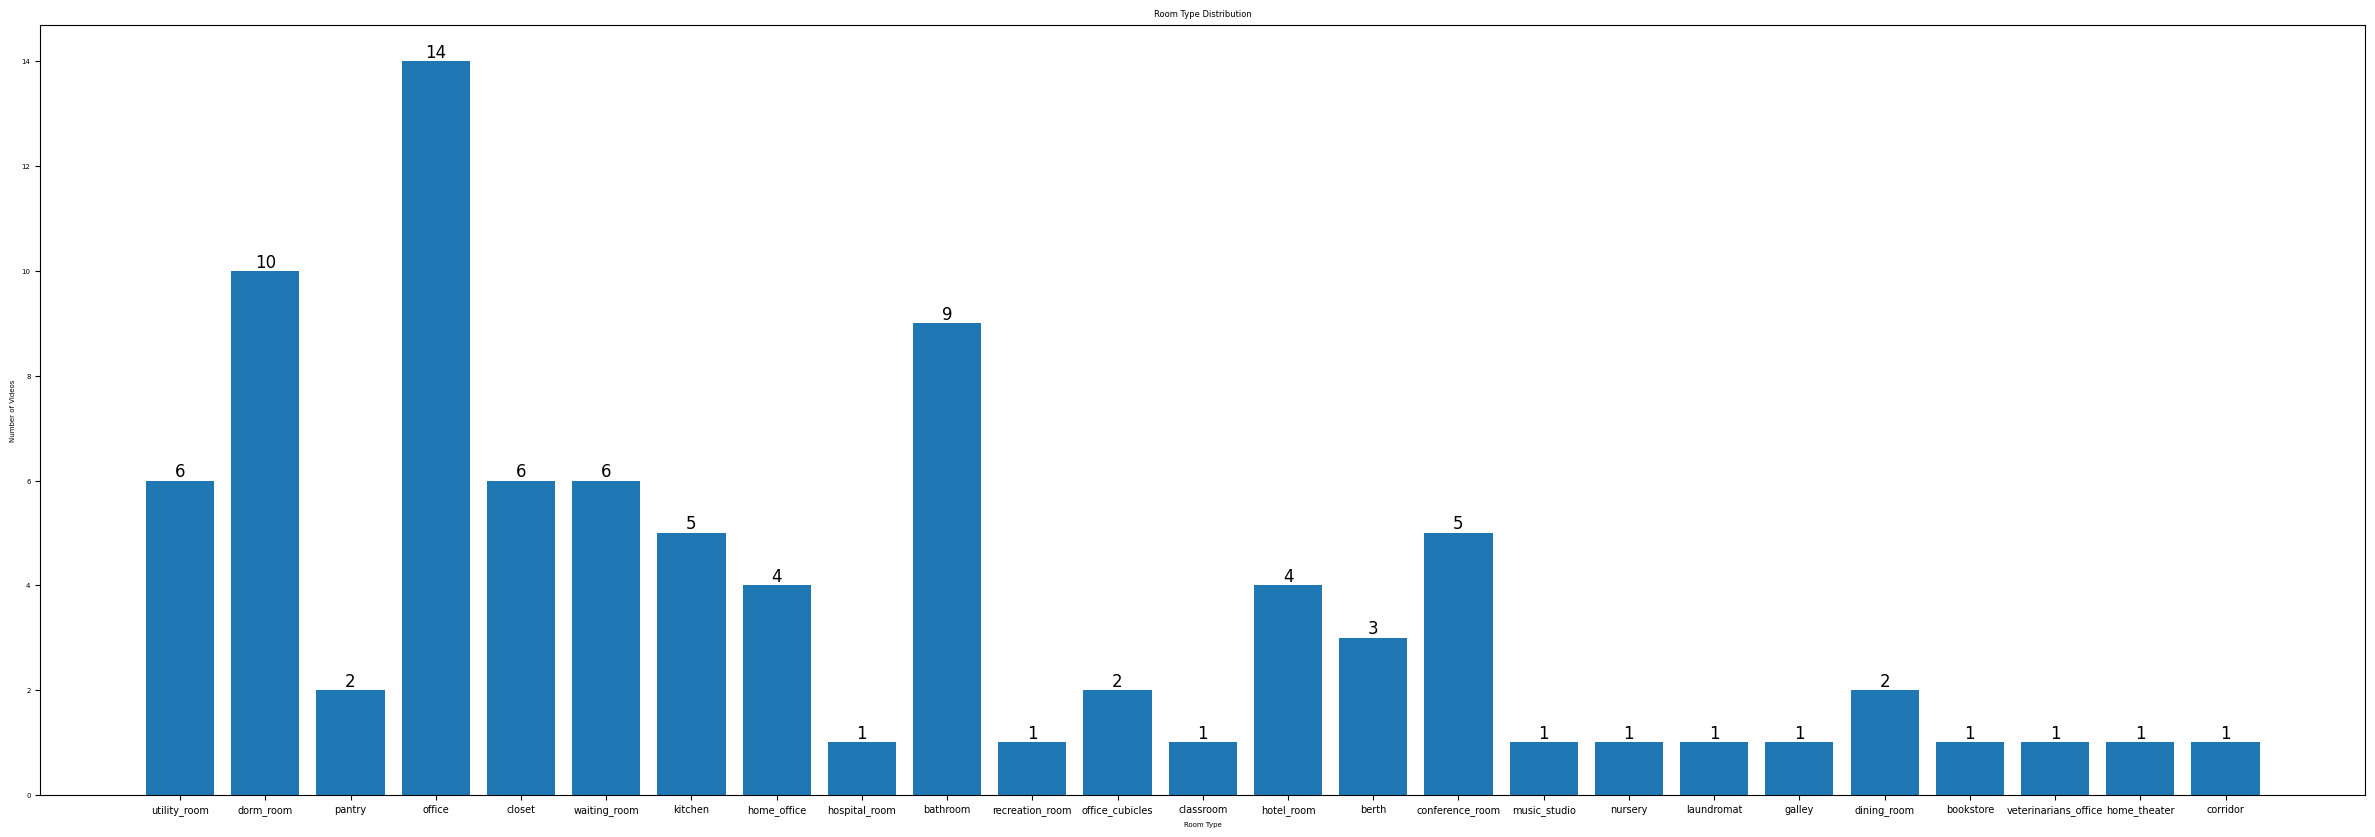

In [51]:
### 시각화
import matplotlib.pyplot as plt

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%({v:d})'.format(pct, v=val)
        return my_format

# 방 종류별 비디오 수
room_types = list(room_count.keys())
room_counts = list(room_count.values())

### 원그래프로 표현
plt.figure(figsize=(20, 20))
plt.pie(room_counts, labels=room_types, autopct='%1.1f%%',  textprops={'fontsize': 12}, rotatelabels = 270, startangle=180)
plt.axis('equal')
plt.show()

### 막대그래프로 표현
plt.figure(figsize=(30, 10))
plt.bar(room_types, room_counts)
plt.title('Room Type Distribution')
plt.xlabel('Room Type')
plt.ylabel('Number of Videos')
### x 값 폰트 사이즈
plt.xticks(fontsize=7)

### 막대그래프 위에 숫자 표시
for i, count in enumerate(room_counts):
    plt.text(i, count, count, ha='center', va='bottom', fontsize=12)

plt.show()
